# Sistem Rekomendasi Destinasi Wisata Berbasis Collaborative Filtering
<hr>


## 1. Mengimpor Library Python yang Dibutuhkan

In [1]:
# Untuk pengolahan data
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Untuk pemodelan
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Untuk menghilangkan warnings saat plotting seaborn
import warnings
warnings.filterwarnings('ignore')

# Untuk mengupload file
import os

## 2. Menyiapkan Dataset yang digunakan

In [2]:
# Upload semua dataset yang dipakai
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 3. Data Understanding

### 3.1 Menyiapkan Data

In [3]:
# Menyimpan masing-masing dataset kedalam variabel

rating = pd.read_csv('tourism_rating.csv')
place = pd.read_csv('tourism_with_id.csv')
user = pd.read_csv('user.csv')

### 3.2 Eksplorasi Fitur-fitur pada Data

#### 3.2.1. Data place

In [4]:
# Melihat gambaran data place

place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2


In [5]:
# Membuang kolom yang tidak dipakai

place = place.drop(['Unnamed: 11','Unnamed: 12'],axis=1)
place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125


In [6]:
place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
dtypes: float64(4), int64(2), object(5)
memory usage: 37.7+ KB


In [7]:
# Membuang kolom yang tidak dipakai

place = place.drop('Time_Minutes', axis=1)

#### 3.2.2. Data rating

In [8]:
# melihat gambaran data rating

rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [9]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [10]:
# Merubah data rating agar hanya berisi rating pada tempat wisata

rating = pd.merge(rating, place[['Place_Id']], how='right', on='Place_Id')
rating.head()

,User_Id,Place_Id,Place_Ratings
0,36,1,4
1,38,1,2
2,64,1,2
3,74,1,2
4,86,1,4


In [11]:
# Melihat ukuran dataset rating

rating.shape

(10000, 3)

#### 3.2.3. Data user

In [12]:
# Melihat gambaran data user

user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [13]:
# Melihat dataset user yang pernah memberi rating pada wisata

user.shape

(300, 3)

## 4. Eksplorasi Data

In [14]:
# Membuat dataframe berisi lokasi dengan jumlah rating terbanyak
top_10 = rating['Place_Id'].value_counts().reset_index()[0:10]
top_10 = pd.merge(top_10, place[['Place_Id','Place_Name']], how='left', left_on='index', right_on='Place_Id')

# Membuat visualisasi wisata dengan jumlah rating terbanyak
plt.figure(figsize=(8,5))
sns.barplot('Place_Id_x', 'Place_Name', data=top_10)
plt.title('Jumlah Tempat Wisata dengan Rating Terbanyak', pad=20)
plt.ylabel('Jumlah Rating')
plt.xlabel('Nama Lokasi')
plt.show()

KeyError: 'index'

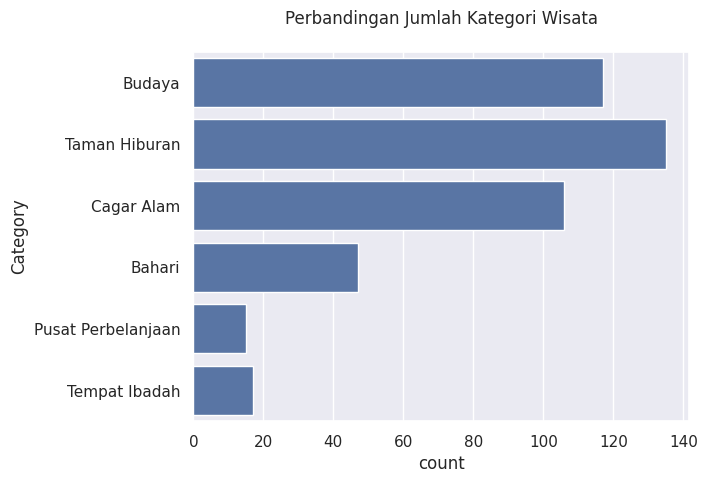

In [15]:
# Membuat visualisasi jumlah kategori wisata

sns.countplot(y='Category', data=place)
plt.title('Perbandingan Jumlah Kategori Wisata', pad=20)
plt.show()

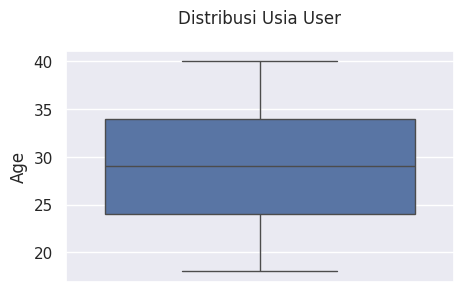

In [16]:
# Membuat visualisasi distribusi usia user

plt.figure(figsize=(5,3))
sns.boxplot(user['Age']);
plt.title('Distribusi Usia User', pad=20)
plt.show()

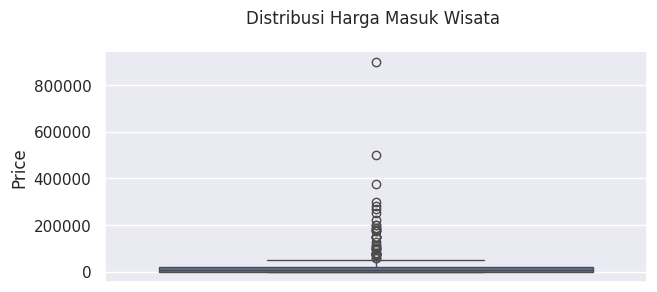

In [17]:
# Membuat visualisasi distribusi harga masuk tempat wisata

plt.figure(figsize=(7,3))
sns.boxplot(place['Price'])
plt.title('Distribusi Harga Masuk Wisata ', pad=20)
plt.show()

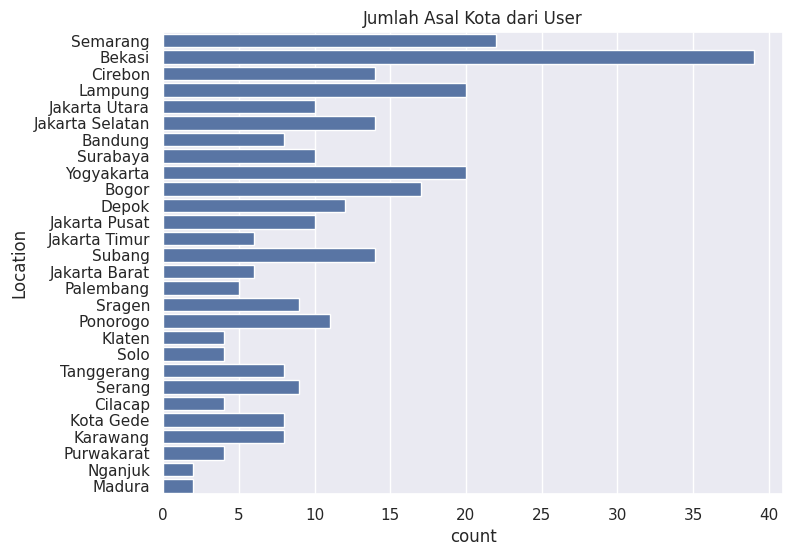

In [18]:
# Memfilter asal kota dari user
askot = user['Location'].apply(lambda x : x.split(',')[0])

# Visualisasi asal kota dari user
plt.figure(figsize=(8,6))
sns.countplot(y=askot)
plt.title('Jumlah Asal Kota dari User')
plt.show()